In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_csv('./merged_data.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175149 entries, 0 to 175148
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   id                              175149 non-null  object        
 1   channel_sales                   175149 non-null  object        
 2   cons_12m                        175149 non-null  int64         
 3   cons_gas_12m                    175149 non-null  int64         
 4   cons_last_month                 175149 non-null  int64         
 5   date_activ                      175149 non-null  datetime64[ns]
 6   date_end                        175149 non-null  datetime64[ns]
 7   date_modif_prod                 175149 non-null  datetime64[ns]
 8   date_renewal                    175149 non-null  datetime64[ns]
 9   forecast_cons_12m               175149 non-null  float64       
 10  forecast_cons_year              175149 non-null  int64  

In [4]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [5]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [6]:
'''creating more features'''

# Time-related features
df['time_since_activation'] = (pd.to_datetime('today') - df['date_activ']).dt.days
df['contract_length'] = (df['date_end'] - df['date_activ']).dt.days

# Usage-related features
df['total_forecasted_consumption'] = df['forecast_cons_12m'] + df['forecast_cons_year']
df['consumption_per_product'] = df['total_forecasted_consumption'] / df['nb_prod_act']

# Financial-related features
df['total_forecasted_cost'] = df['total_forecasted_consumption'] * df['forecast_price_energy_off_peak']
df['gross_profit_margin'] = (df['margin_gross_pow_ele'] / df['total_forecasted_cost']) * 100
df['net_profit_margin'] = (df['margin_net_pow_ele'] / df['total_forecasted_cost']) * 100

# Interaction features
df['interaction_forecasted'] = df['forecast_cons_12m'] * df['forecast_discount_energy']

# Historical trends
df['rolling_average_consumption'] = df['forecast_cons_12m'].rolling(window=3).mean()
df['rolling_average_price'] = df['forecast_price_energy_off_peak'].rolling(window=3).mean()





In [7]:
df = pd.merge(df, diff, on='id', how='left')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,total_forecasted_consumption,consumption_per_product,total_forecasted_cost,gross_profit_margin,net_profit_margin,interaction_forecasted,rolling_average_consumption,rolling_average_price,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,...,0.0,0.0,0.0,inf,inf,0.0,NaN,NaN,0.020057,3.700961
1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,...,0.0,0.0,0.0,inf,inf,0.0,NaN,NaN,0.020057,3.700961
2,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,...,0.0,0.0,0.0,inf,inf,0.0,0.0,0.114481,0.020057,3.700961
3,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,...,0.0,0.0,0.0,inf,inf,0.0,0.0,0.114481,0.020057,3.700961
4,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,...,0.0,0.0,0.0,inf,inf,0.0,0.0,0.114481,0.020057,3.700961


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175149 entries, 0 to 175148
Data columns (total 46 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   id                               175149 non-null  object        
 1   channel_sales                    175149 non-null  object        
 2   cons_12m                         175149 non-null  int64         
 3   cons_gas_12m                     175149 non-null  int64         
 4   cons_last_month                  175149 non-null  int64         
 5   date_activ                       175149 non-null  datetime64[ns]
 6   date_end                         175149 non-null  datetime64[ns]
 7   date_modif_prod                  175149 non-null  datetime64[ns]
 8   date_renewal                     175149 non-null  datetime64[ns]
 9   forecast_cons_12m                175149 non-null  float64       
 10  forecast_cons_year               175149 non-

In [9]:

datetime_columns = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']

# Check if the datetime columns exist in the DataFrame
for datetime_column_name in datetime_columns:
    if datetime_column_name in df.columns:
        # Convert datetime column to individual features
        df[f'{datetime_column_name}_year'] = df[datetime_column_name].dt.year
        df[f'{datetime_column_name}_month'] = df[datetime_column_name].dt.month
        df[f'{datetime_column_name}_day'] = df[datetime_column_name].dt.day

        # Drop the original datetime column
        df = df.drop([datetime_column_name], axis=1)
    else:
        print(f"The column '{datetime_column_name}' does not exist in the DataFrame.")

In [10]:
df.shape

(175149, 54)

In [11]:
'''data cleaning'''

# Drop rows with missing values in the features
df = df.dropna()

# Drop rows with infinity values in the features
df = df.reset_index(drop=True)
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)]

# Drop all object-type columns
df = df.select_dtypes(exclude=['object'])

In [12]:
'''removing highly correlated features'''

# Remove non-numeric columns before calculating correlation
numeric_columns = df.select_dtypes(include=[np.number]).columns
numeric_df = df[numeric_columns]

# Calculate correlation matrix
corr_matrix = numeric_df.corr().abs()

# Find highly correlated features
correlation_threshold = 0.8
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > correlation_threshold)]

# Exclude columns related to price sensitivities from removal
exclude_columns = ['price_off_peak_var', 'price_peak_var', 'price_mid_peak_var', 
                   'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix', 'price_sensitivity']

# Drop highly correlated features excluding those related to price sensitivities
df = df.drop([col for col in high_corr_features if col not in exclude_columns], axis=1)


In [13]:
df.columns

Index(['cons_12m', 'cons_gas_12m', 'forecast_cons_12m', 'forecast_cons_year',
       'forecast_discount_energy', 'forecast_meter_rent_12m',
       'forecast_price_energy_off_peak', 'forecast_price_energy_peak',
       'forecast_price_pow_off_peak', 'margin_gross_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max', 'churn',
       'price_off_peak_var', 'price_peak_var', 'price_mid_peak_var',
       'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix',
       'price_sensitivity', 'gross_profit_margin', 'interaction_forecasted',
       'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power',
       'date_activ_month', 'date_activ_day', 'date_end_year', 'date_end_day',
       'date_modif_prod_year', 'date_modif_prod_month', 'date_modif_prod_day',
       'date_renewal_year', 'date_renewal_day'],
      dtype='object')

In [14]:
train_df, test_df = train_test_split(df, test_size=0.2)

In [15]:
'''model training'''

# Drop all object-type columns
train_df = train_df.select_dtypes(exclude=['object'])


# Split the data into features (X) and target variable (y)
X = train_df.drop(['churn'], axis=1)
y = train_df['churn']


# Scale the input data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Train the model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_scaled, y)


RandomForestClassifier(random_state=42)

In [16]:
'''test model on an unseen dataset'''

# Drop all object-type columns
test_df = test_df.select_dtypes(exclude=['object'])

# Split the data into features (X_test) and target variable (y_test)
X_test = test_df.drop(['churn'], axis=1)
y_test = test_df['churn']

# Scale the input data using the same scaler used for training data
X_test_scaled = scaler.transform(X_test)

# Make predictions on the test set
y_pred_test = rf_classifier.predict(X_test_scaled)

# Print predicted and actual values
for pred, actual in zip(y_pred_test, y_test):
    print(f"Predicted: {pred}, Actual: {actual}")


Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Ac

In [17]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test)

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

Accuracy: 1.0000
Precision: 1.0000
Recall: 0.9997
F1 Score: 0.9999
ROC AUC: 0.9999


Confusion Matrix:
[[31028     0]
 [    1  3349]]


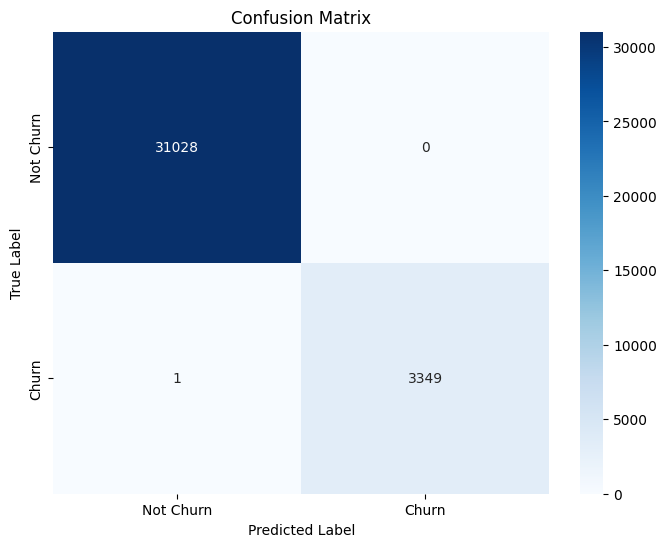

In [18]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [19]:
'''Identifying High Propensity to Churn Customers'''
# Using the trained model to predict churn probabilities
churn_probabilities = rf_classifier.predict_proba(X)[:, 1]
churn_probabilities

C:\Users\tunmi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([0.39, 0.4 , 0.37, ..., 0.34, 0.41, 0.37])

In [20]:
# threshold to identify high propensity to churn customers
threshold = 0.5
high_churn_indices = np.where(churn_probabilities > threshold)[0]

# the high propensity to churn customers
high_churn_customers = df.iloc[high_churn_indices]
high_churn_customers

,cons_12m,cons_gas_12m,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,margin_gross_pow_ele,...,offpeak_diff_dec_january_power,date_activ_month,date_activ_day,date_end_year,date_end_day,date_modif_prod_year,date_modif_prod_month,date_modif_prod_day,date_renewal_year,date_renewal_day
7755,10175,0,465.61,376,0.0,17.08,0.144902,0.000000,44.311378,24.42,...,0.177779,5,11,2016,11,2009,5,11,2015,14
13025,17568,0,254.83,318,0.0,16.18,0.144963,0.000000,44.311378,26.04,...,0.177779,1,10,2017,10,2015,11,18,2016,11
20367,1942,3650,287.16,431,0.0,16.47,0.142416,0.000000,44.311378,21.48,...,0.177779,11,8,2016,26,2015,8,26,2014,19
72429,5401,11878,1096.17,0,0.0,38.08,0.245926,0.168032,53.284378,0.00,...,8.963999,1,18,2017,18,2013,1,18,2016,19
95884,6027,0,882.01,1258,0.0,16.31,0.141434,0.000000,44.311378,12.36,...,0.177779,8,17,2016,17,2015,6,17,2015,18
101952,0,0,2606.53,0,26.0,0.00,0.210680,0.107428,45.806878,24.63,...,0.183780,9,21,2016,11,2015,9,20,2015,12
128092,3209,0,478.75,284,0.0,15.18,0.144039,0.000000,45.806878,21.72,...,0.177779,12,9,2016,9,2015,11,1,2015,10
132573,9834,0,1474.87,0,0.0,17.30,0.145711,0.000000,44.311378,25.56,...,0.177779,6,7,2016,7,2015,11,1,2015,23
135172,17321,128,1736.25,4498,0.0,148.04,0.113509,0.098391,40.606701,0.84,...,0.000000,12,14,2016,14,2015,11,18,2015,16


In [26]:
'''Proposed Discounting Strategy'''

discount_percentage = 0.2

price_columns = ['price_off_peak_var', 'price_peak_var', 'price_mid_peak_var', 
                 'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix']

# new column for discounted price
for col in price_columns:
    high_churn_customers.loc[:, f'discounted_{col}'] = high_churn_customers.loc[:, col] * (1 - discount_percentage)

## The Hypothesis

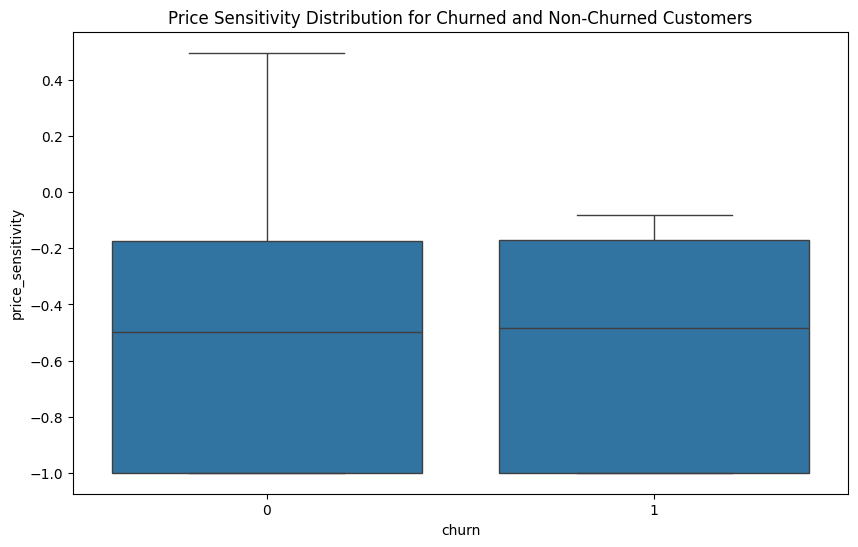

T-test p-value: 1.4792679400894483e-44
Correlation between churn and price sensitivity: 0.03376747493339957
Price Sensitivity Importance: 0.007165342269872507


In [22]:
# Hypothesis 1: Churn is Driven by Customers' Price Sensitivities

plt.figure(figsize=(10, 6))
sns.boxplot(x='churn', y='price_sensitivity', data=df)
plt.title('Price Sensitivity Distribution for Churned and Non-Churned Customers')
plt.show()

# Statistical Testing

churned_prices = df[df['churn'] == 1]['price_sensitivity']
non_churned_prices = df[df['churn'] == 0]['price_sensitivity']

t_stat, p_value = ttest_ind(churned_prices, non_churned_prices)
print(f'T-test p-value: {p_value}')

# Correlation Analysis
correlation = df[['churn', 'price_sensitivity']].corr().iloc[0, 1]
print(f'Correlation between churn and price sensitivity: {correlation}')


price_sensitivity_importance = rf_classifier.feature_importances_[X.columns.get_loc('price_sensitivity')]
print(f'Price Sensitivity Importance: {price_sensitivity_importance}')

In [23]:
# Feature Importance Analysis
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)
print('Top 10 Feature Importances:')
print(feature_importances.head(10))

Top 10 Feature Importances:
cons_12m                           0.074019
margin_gross_pow_ele               0.072474
net_margin                         0.068358
forecast_meter_rent_12m            0.068160
gross_profit_margin                0.067102
forecast_cons_12m                  0.064247
pow_max                            0.051089
offpeak_diff_dec_january_energy    0.047512
forecast_cons_year                 0.044384
date_activ_day                     0.042646
dtype: float64


In [24]:
cross_val_scores = cross_val_score(rf_classifier, X_scaled, y, cv=5, scoring='accuracy')
print(f'Cross-Validation Mean Accuracy: {cross_val_scores.mean():.4f}')

Cross-Validation Mean Accuracy: 1.0000


In [25]:
# Discounting Strategy Analysis
discount_effect = high_churn_customers[f'discounted_{price_columns[0]}'].mean()
print(f'Mean Discount for High Churn Propensity Customers: {discount_effect:.2%}')



Mean Discount for High Churn Propensity Customers: 13.26%


## Task 2 Report: Churn Prediction Model Evaluation
### Problem Representation:
The problem at hand is best represented as a classification task. We aim to predict whether a customer will churn or not, a binary outcome.
### Model Performance Goals:
The appropriate model performance depends on business priorities. We should aim for a balance between precision and recall, considering the business implications of false positives and false negatives.
### Performance Metrics:
Using key metrics such as accuracy, precision, recall, and F1 score provides a comprehensive understanding of the model's effectiveness. Additionally, AUC-ROC score gauges the model's discriminatory power.   
### Business Metrics Integration:
Tie model performance to business metrics by conducting a cost-benefit analysis. Consider the financial impact of false positives (unnecessary retention costs) and false negatives (customer churn costs). Optimize the model's threshold to align with business objectives.
Adjust the threshold based on the business's risk tolerance and the relative costs of retention efforts and losing a customer. Striking the right balance will maximize the overall benefit to the business.
This approach ensures that the model aligns with business goals, optimizing the trade-off between precision and recall based on the tangible impact on the company's bottom line.
